In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")

In [5]:
from pathlib import Path
from hallucinations.utils.metric_loader import get_activation_dirs, load_model_answers, load_model_metrics, compute_model_results


data_dir = Path(f"../data/activations/trivia_qa")
activations_dirs = get_activation_dirs(data_dir, dataset="trivia_qa")
model_answers = load_model_answers(activations_dirs)
model_results = compute_model_results(model_answers)

Evaluating ROUGE metrics: 100%|██████████| 3842/3842 [00:00<00:00, 8744.13it/s]


In [12]:
from tqdm.notebook import tqdm
from hallucinations.utils.metric_loader import load_model_metrics_as_df

METRICS = ["erank", "diff_erank", "logdet"]
id_cols = ["model", "temperature", "squad_f1", "squad_exact_match", "rougeL_fmeasure", "rougeL_precision", "rougeL_recall"]

dfs_melted = {}

for metric in tqdm(METRICS):
    df_metrics = load_model_metrics_as_df(model_results, metric_type=metric)
    df_melted = df_metrics.melt(
        id_vars=id_cols,
        value_vars=[f"{metric}_layer_{i}" for i in range(33)],
        var_name="layer",
        value_name=metric
    )
    df_melted["correct"] = df_melted["rougeL_fmeasure"].apply(lambda x: 1 if x >= 0.3 else 0)
    df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)
    dfs_melted[metric] = df_melted


<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_94905/734038324.py:18: SyntaxWarning: invalid escape sequence '\d'
  df_melted["layer"] = df_melted["layer"].str.extract("(\d+)").astype(int)


  0%|          | 0/3 [00:00<?, ?it/s]

# Plot metric values

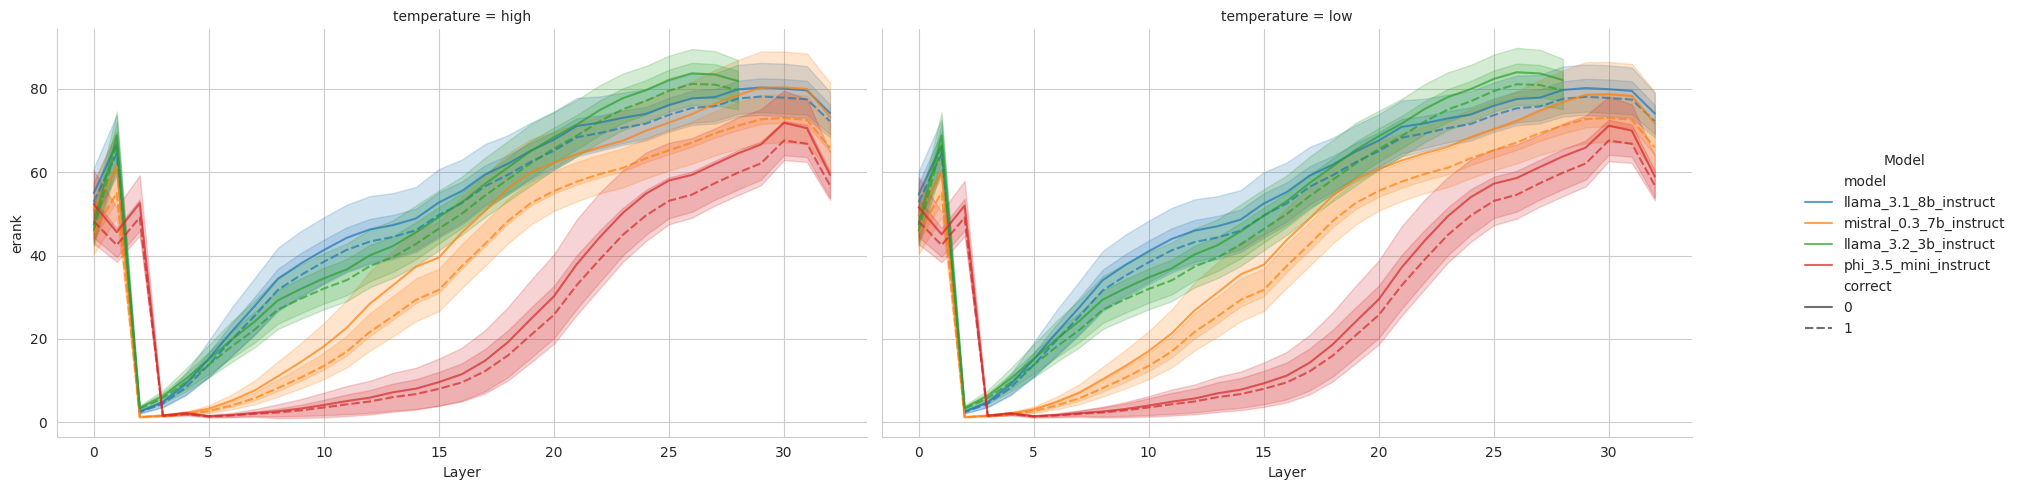

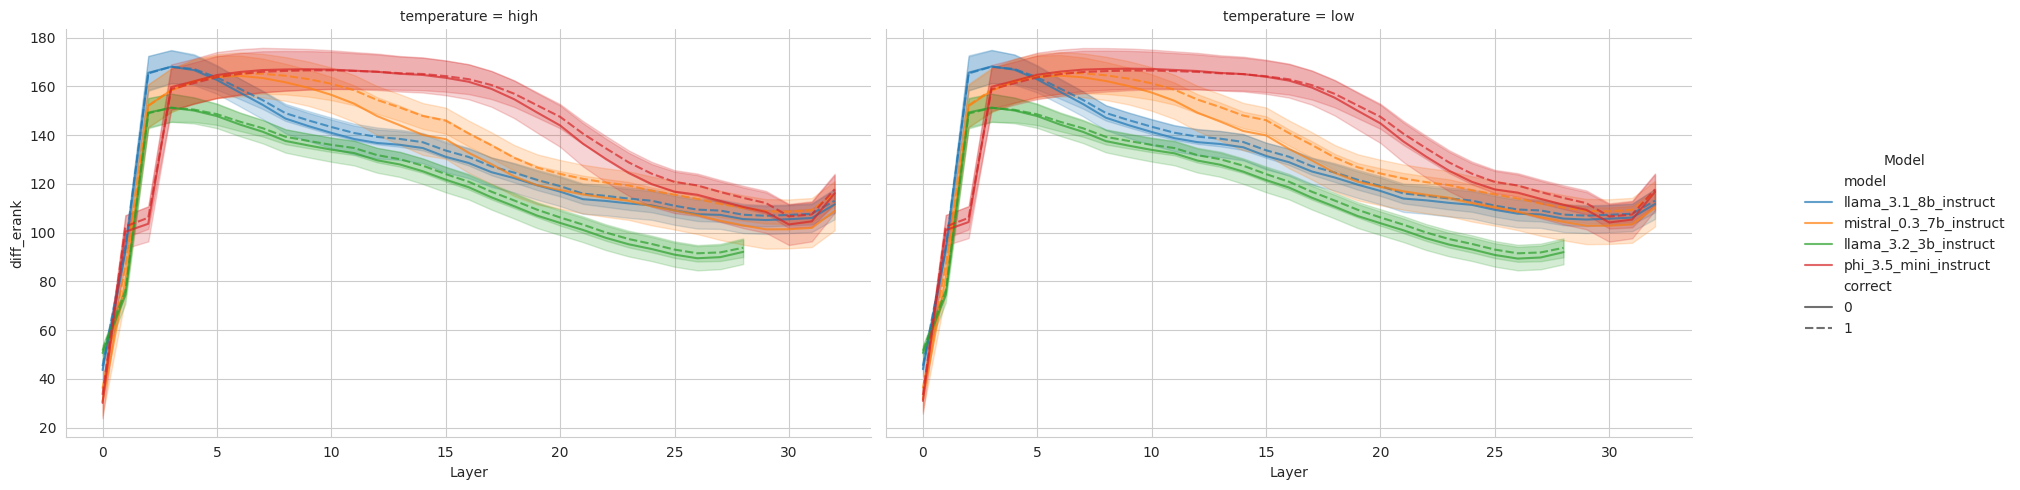

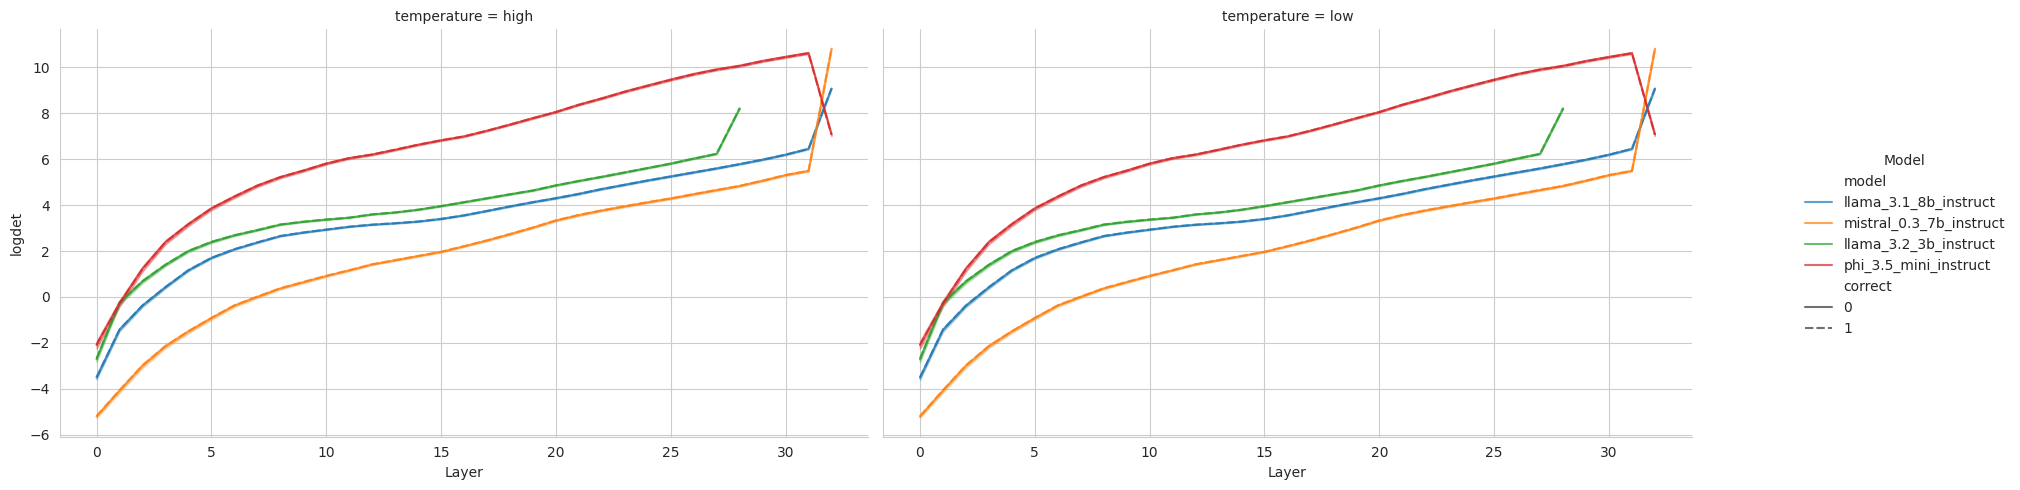

In [13]:
for metric in METRICS:
    g = sns.FacetGrid(
        data=dfs_melted[metric],
        col="temperature",
        height=5,
        aspect=1.5
    )

    g.map_dataframe(
        sns.lineplot,
        x="layer",
        y=metric,
        hue="model",
        style="correct", 
        alpha=0.7,
        errorbar="sd",
    )

    g.set_axis_labels("Layer", metric)

    # Move legend next to plot by adjusting bbox_to_anchor coordinates
    g.add_legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title="Model")

    plt.tight_layout()
    plt.show()


# AUROC per layers

In [14]:
from sklearn.metrics import roc_auc_score

model_names = ['llama_3.2_3b_instruct', 'llama_3.1_8b_instruct', 'llama_3.1_8b', 'mistral_0.3_7b_instruct', 'phi_3.5_mini_instruct']

auroc_results = []

for metric in METRICS:
    df_plot = dfs_melted[metric].dropna(subset=[metric])
    df_plot = df_plot[df_plot[metric] != 0.]

    for model in model_names:
        for temperature in ["low", "high"]:
            model_data = df_plot[(df_plot["model"] == model) & (df_plot["temperature"] == temperature)]
            
            for layer in model_data["layer"].unique():
                layer_data = model_data[model_data["layer"] == layer]
                
                if layer_data["correct"].nunique() < 2:
                    continue
                
                if metric == "diff_erank":
                    auroc = roc_auc_score(layer_data["correct"], layer_data[metric])
                else:
                    auroc = 1 - roc_auc_score(layer_data["correct"], layer_data[metric])
                
                auroc_results.append({
                    "model": model,
                    "layer": layer,
                    "auroc": auroc,
                    "temperature": temperature,
                    "metric": metric
                })


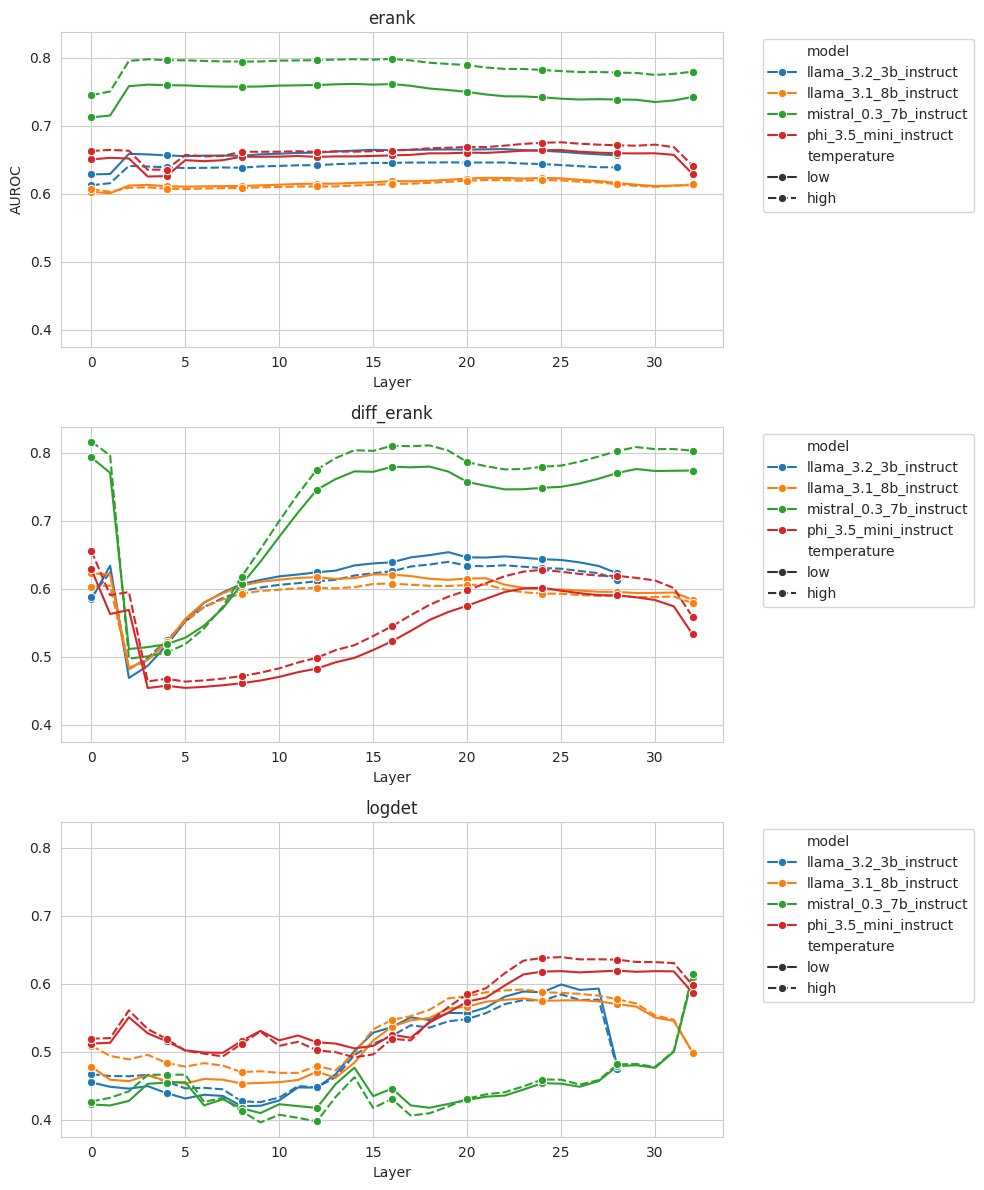

In [17]:
auroc_df = pd.DataFrame(auroc_results)

fig, axes = plt.subplots(nrows=len(METRICS), ncols=1, figsize=(10, 4 * len(METRICS)), sharey=True)

for ax, metric in zip(axes, METRICS):
    sns.lineplot(
        data=auroc_df[(auroc_df["auroc"] != 0.5) & (auroc_df["metric"] == metric)],
        x="layer",
        y="auroc", 
        hue="model",
        style="temperature",
        marker="o",
        markevery=4,
        ax=ax
    )
    ax.set_title(metric)
    ax.set_xlabel("Layer")
    ax.set_ylabel("AUROC" if ax == axes[0] else "")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

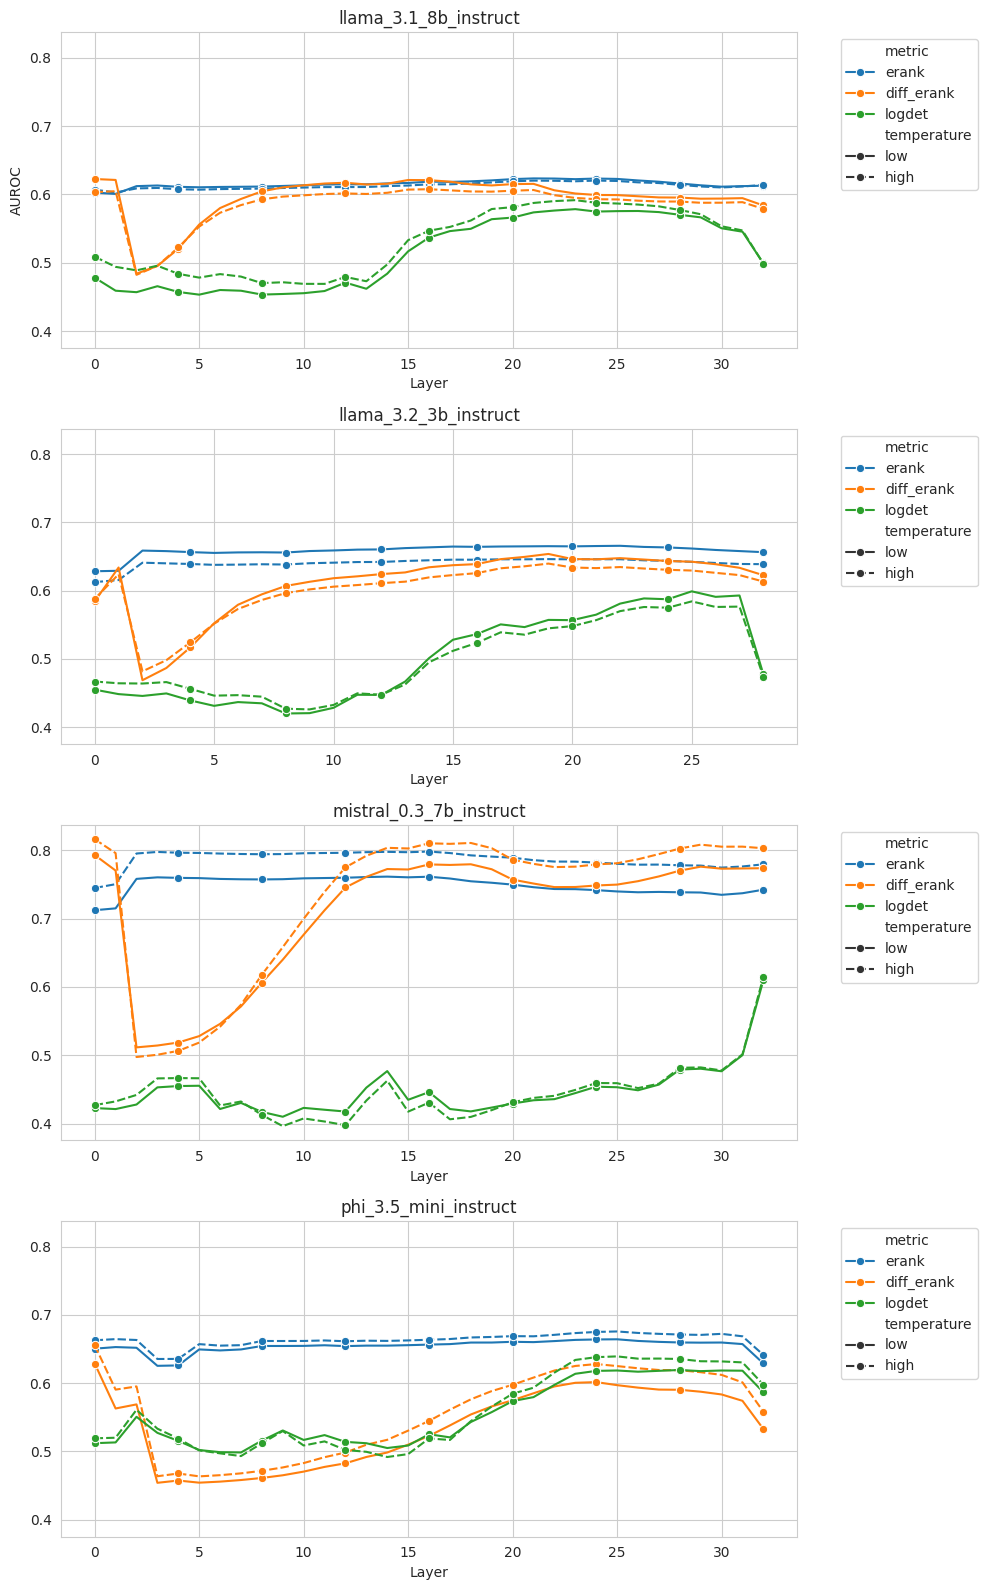

In [18]:
auroc_df = pd.DataFrame(auroc_results)

fig, axes = plt.subplots(nrows=len(set(auroc_df["model"])), ncols=1, figsize=(10, 4 * len(set(auroc_df["model"]))), sharey=True)

for ax, model in zip(axes, sorted(auroc_df["model"].unique())):
    sns.lineplot(
        data=auroc_df[(auroc_df["auroc"] != 0.5) & (auroc_df["model"] == model)],
        x="layer",
        y="auroc",
        hue="metric",
        style="temperature", 
        marker="o",
        markevery=4,
        ax=ax
    )
    ax.set_title(model)
    ax.set_xlabel("Layer")
    ax.set_ylabel("AUROC" if ax == axes[0] else "")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

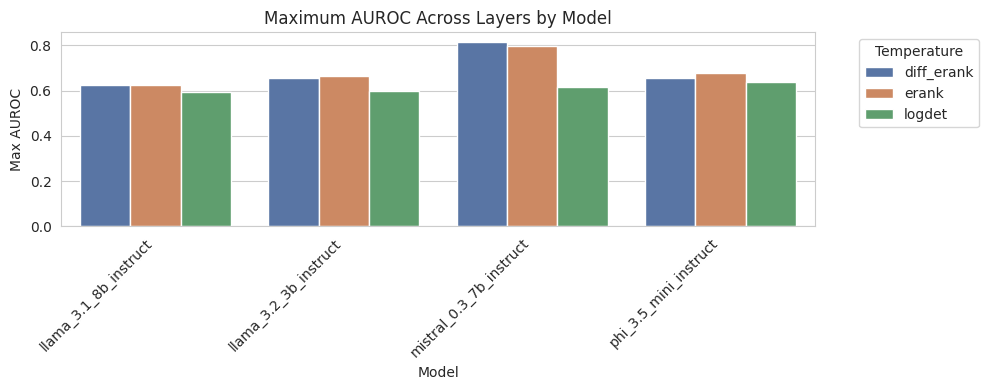

In [19]:
max_auroc_df = auroc_df.groupby(['model', 'metric'])['auroc'].max().reset_index()


plt.figure(figsize=(10, 4))
sns.barplot(
    data=max_auroc_df,
    x='model',
    y='auroc',
    hue='metric',
    palette='deep'
)

plt.title("Maximum AUROC Across Layers by Model")
plt.xlabel("Model")
plt.ylabel("Max AUROC")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Temperature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- **The hallucination detection abilities are not correlated with accuracy in the downstream task:**  
  - Mistral achieves the highest AUROC in detecting hallucinated samples, even though its performance in the task (e.g., QA accuracy/F1) is not the best. LLaMA performs better in accuracy/F1 but worse in hallucination detection.  
- **Token masking improves hallucination detection:**  
  - Masking allows for better and earlier detection of hallucinated samples.  
- **The effect of temperature:**  
  - Temperature significantly impacts hallucination detection for some models.  
- **LLaMA (pretrained) struggles with hallucination detection:**  
  - Pretrained LLaMA (before instruction tuning) cannot effectively detect hallucinations and also performs poorly in answering tasks.  